# Demo of optimisation-based reconstruction in CIL

### The case is a 3D parallel-beam synchrotron dataset of a steel wire.

First we import everything we need:

In [1]:
# Import all CIL components needed
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.framework import BlockDataContainer

from cil.optimisation.algorithms import CGLS, GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, \
                                       GradientOperator, FiniteDifferenceOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

# CIL Processors
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

from cil.utilities.display import show2D

# Import from cil.plugins.astra
from cil.plugins.astra.processors import FBP, AstraBackProjector3D
from cil.plugins.astra.operators import ProjectionOperator, AstraProjector3DSimple

# All external imports
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy

Exactly as in the notebook 03_preprocessingfrom week 1, we load the steel-wire demonstration data provided as part of CIL, carry out some preprocessing and FBP reconstructions for reference:

In [12]:
# Imports
from cil.utilities.dataexample import SYNCHROTRON_PARALLEL_BEAM_DATA
data_sync = SYNCHROTRON_PARALLEL_BEAM_DATA.get()

# Preprocessing
scale = data_sync.get_slice(vertical=20).mean()
data_sync = data_sync/scale
data_sync = TransmissionAbsorptionConverter()(data_sync)
data_sync = CentreOfRotationCorrector.xcorrelation(slice_index='centre')(data_sync)

# Crop data and reorder for ASTRA backend
data90 = Slicer(roi={'angle':(0,90), 
                     'horizontal':(20,140,1)})(data_sync)
data90.reorder(order='astra')

# Set up and run FBP for 90-angle dataset
ag90 = data90.geometry
ig = ag90.get_ImageGeometry()
recon90 = FBP(ig, ag90, device='gpu')(data90)

# Set up and run FBP for 15-angle dataset
data15 = Slicer(roi={'angle': (0,90,6)})(data90)
ag = data15.geometry
recon15 = FBP(ig, ag, device='gpu')(data15)

In [13]:
# Define custom display function to reuse for visualizing all reconstructions consistently
sx = 44
sz = 103
ca1 = -0.01
ca2 =  0.11
myshow = lambda vol : show2D(vol, slice_list=[('horizontal_x',sx),('vertical',sz)], cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

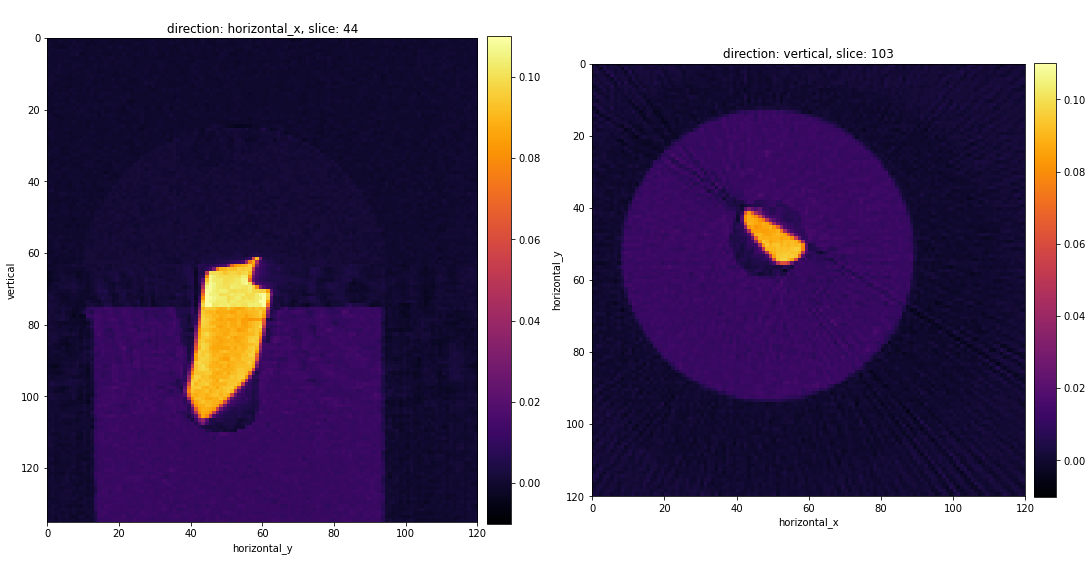

In [14]:
myshow(recon90)

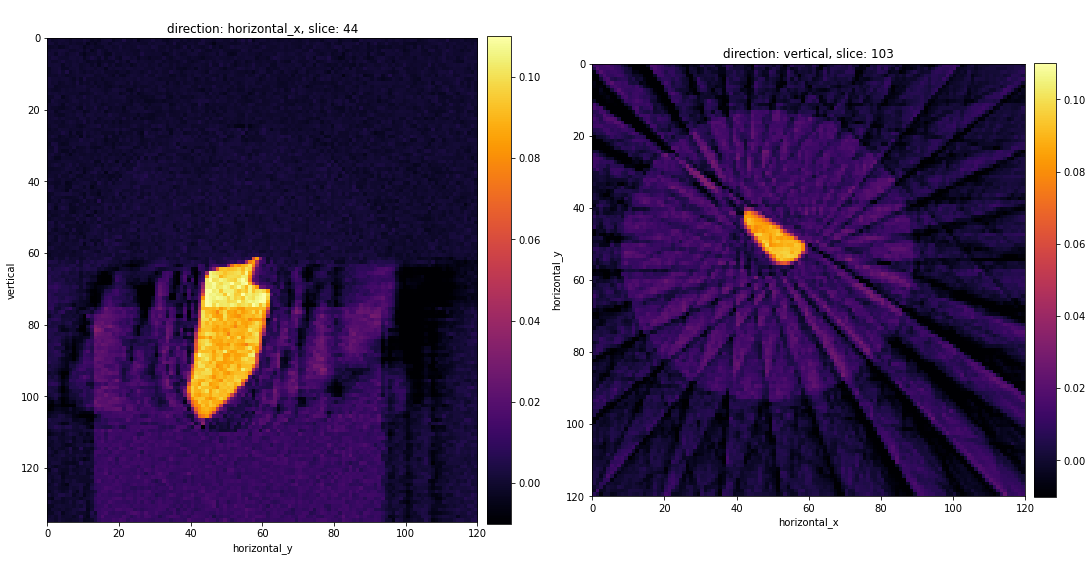

In [15]:
myshow(recon15)

The first thing we are going to need is the LinearOperator representing forward and back-projections. We set up the ProjectionOperator from the CIL-ASTRA plugin by passing the 15-projection image and acquisition geometries:

In [16]:
A = ProjectionOperator(ig, ag)

In iterative algorithms we must provide an initial point from which to start, here we choose the zero image. We further use `b` to refer to the dataset:

In [17]:
x0 = ig.allocate(0.0)
b = data15

In [24]:
myCGLS = CGLS(x_init=x0, operator=A, data=b, max_iteration=1000)

CGLS setting up
CGLS configured


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          8.11749e+04
        1       1000         0.037          1.67888e+04
        2       1000         0.033          3.51453e+03
-------------------------------------------------------
        2       1000         0.033          3.51453e+03
Stop criterion has been reached.



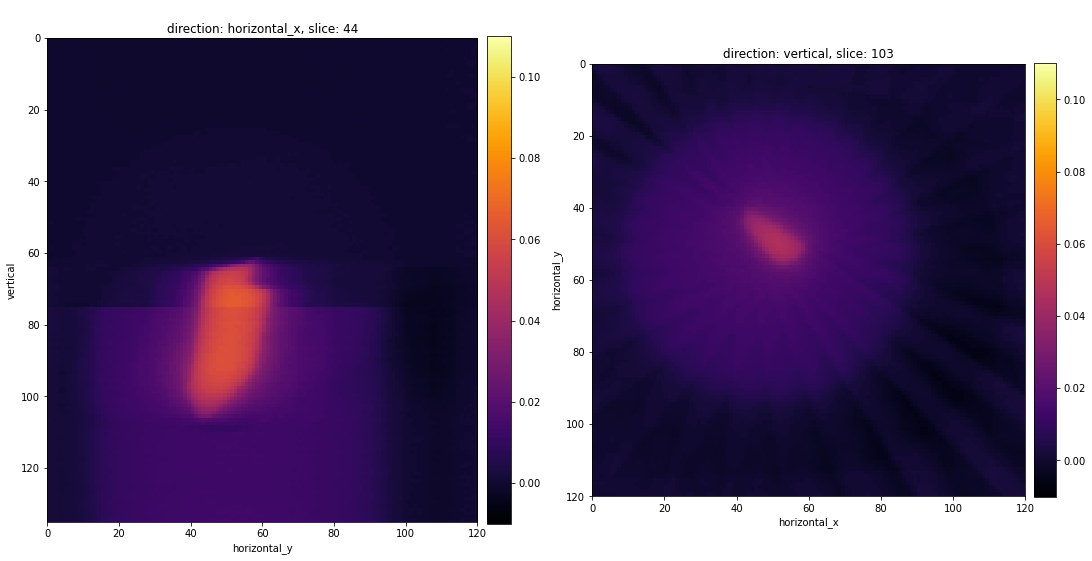

In [25]:
myCGLS.run(2,verbose=True)
myshow(myCGLS.solution)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        2       1000         0.033          3.51453e+03
        3       1000         0.033          1.13017e+03
        4       1000         0.033          1.71267e+02
        5       1000         0.031          3.68648e+01
        6       1000         0.030          2.60843e+01
        7       1000         0.030          1.16842e+01
        8       1000         0.029          7.70993e+00
        9       1000         0.028          6.52567e+00
       10       1000         0.029          5.95368e+00
       11       1000         0.029          5.55439e+00
       12       1000         0.029          5.05755e+00
       13       1000         0.028          4.63169e+00
       14       1000         0.028          4.48641e+00
       15       1000         0.028          4.21921e+00
       16       1000         0.028          3.90601e+00
       17       1000         0.028          3.75

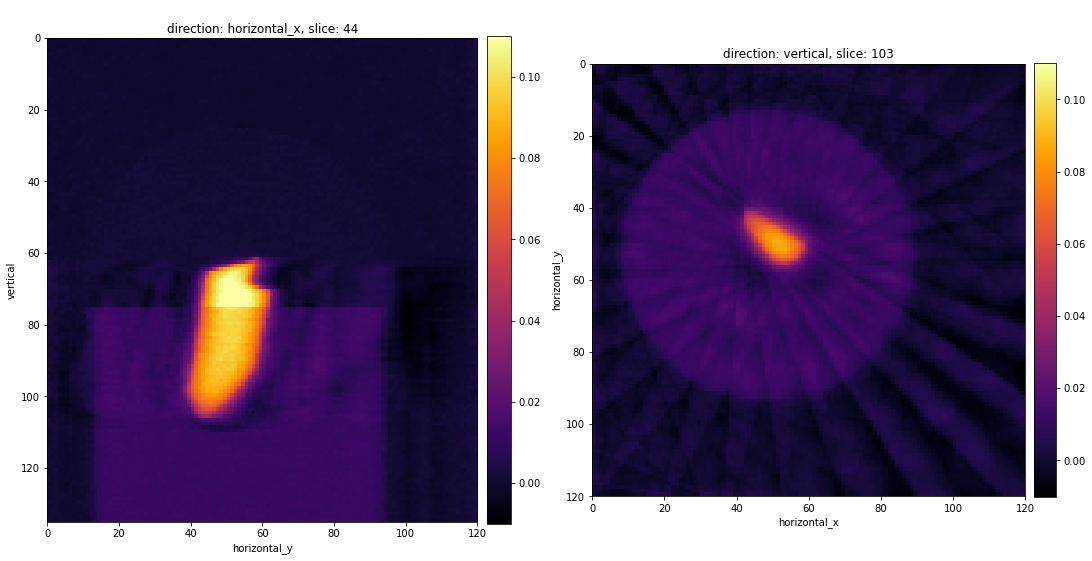

In [26]:
myCGLS.run(18,verbose=1)
myshow(myCGLS.solution)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       20       1000         0.027          3.28010e+00
       21       1000         0.028          3.18489e+00
       22       1000         0.028          3.14245e+00
       23       1000         0.028          3.06220e+00
       24       1000         0.029          2.99354e+00
       25       1000         0.029          2.93541e+00
       26       1000         0.029          2.91535e+00
       27       1000         0.029          2.83614e+00
       28       1000         0.029          2.79021e+00
       29       1000         0.029          2.75964e+00
       30       1000         0.030          2.71101e+00
       31       1000         0.030          2.66658e+00
       32       1000         0.030          2.63688e+00
       33       1000         0.031          2.62462e+00
       34       1000         0.031          2.58456e+00
       35       1000         0.031          2.55

      170       1000         0.034          1.63616e+00
      171       1000         0.034          1.63543e+00
      172       1000         0.034          1.63202e+00
      173       1000         0.035          1.62962e+00
      174       1000         0.035          1.62856e+00
      175       1000         0.035          1.62622e+00
      176       1000         0.035          1.62393e+00
      177       1000         0.035          1.62156e+00
      178       1000         0.035          1.62021e+00
      179       1000         0.035          1.61709e+00
      180       1000         0.035          1.61286e+00
      181       1000         0.035          1.61179e+00
      182       1000         0.035          1.60942e+00
      183       1000         0.035          1.60644e+00
      184       1000         0.035          1.60404e+00
      185       1000         0.035          1.60248e+00
      186       1000         0.035          1.59969e+00
      187       1000         0.035          1.59

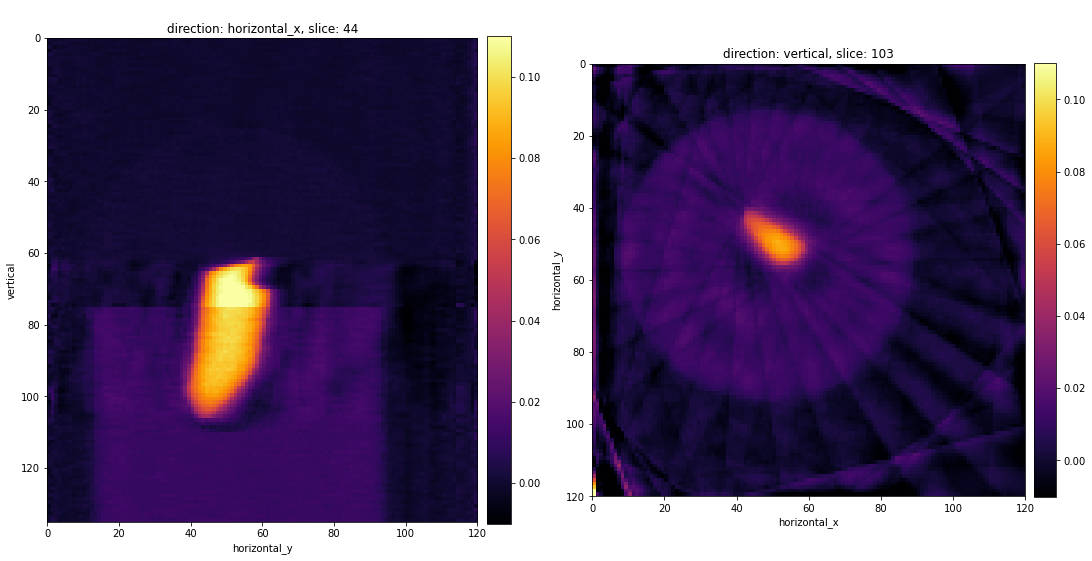

In [27]:
myCGLS.run(180,verbose=True)
myshow(myCGLS.solution)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      200       1000         0.035          1.56755e+00
      201       1000         0.035          1.56525e+00
      202       1000         0.035          1.56403e+00
      203       1000         0.035          1.56170e+00
      204       1000         0.035          1.55937e+00
      205       1000         0.035          1.55776e+00
      206       1000         0.035          1.55653e+00
      207       1000         0.035          1.55352e+00
      208       1000         0.035          1.55137e+00
      209       1000         0.035          1.55030e+00
      210       1000         0.035          1.54830e+00
      211       1000         0.035          1.54614e+00
      212       1000         0.035          1.54422e+00
      213       1000         0.035          1.54302e+00
      214       1000         0.035          1.53905e+00
      215       1000         0.035          1.53

      350       1000         0.036          1.31667e+00
      351       1000         0.036          1.31480e+00
      352       1000         0.036          1.31406e+00
      353       1000         0.036          1.31187e+00
      354       1000         0.036          1.31035e+00
      355       1000         0.036          1.30968e+00
      356       1000         0.036          1.30838e+00
      357       1000         0.036          1.30691e+00
      358       1000         0.036          1.30555e+00
      359       1000         0.036          1.30480e+00
      360       1000         0.036          1.30293e+00
      361       1000         0.036          1.30190e+00
      362       1000         0.036          1.30101e+00
      363       1000         0.036          1.29963e+00
      364       1000         0.036          1.29800e+00
      365       1000         0.036          1.29678e+00
      366       1000         0.036          1.29543e+00
      367       1000         0.036          1.29

      497       1000         0.037          1.14729e+00
      498       1000         0.037          1.14589e+00
      499       1000         0.037          1.14529e+00
      500       1000         0.037          1.14394e+00
      501       1000         0.037          1.14261e+00
      502       1000         0.037          1.14210e+00
      503       1000         0.036          1.14124e+00
      504       1000         0.037          1.14043e+00
      505       1000         0.036          1.13964e+00
      506       1000         0.036          1.13922e+00
      507       1000         0.036          1.13815e+00
      508       1000         0.036          1.13712e+00
      509       1000         0.036          1.13655e+00
      510       1000         0.036          1.13567e+00
      511       1000         0.036          1.13429e+00
      512       1000         0.036          1.13354e+00
      513       1000         0.036          1.13214e+00
      514       1000         0.036          1.13

      648       1000         0.036          1.02400e+00
      649       1000         0.036          1.02341e+00
      650       1000         0.036          1.02241e+00
      651       1000         0.036          1.02190e+00
      652       1000         0.036          1.02110e+00
      653       1000         0.036          1.02043e+00
      654       1000         0.036          1.01968e+00
      655       1000         0.036          1.01934e+00
      656       1000         0.036          1.01846e+00
      657       1000         0.036          1.01766e+00
      658       1000         0.036          1.01734e+00
      659       1000         0.036          1.01648e+00
      660       1000         0.036          1.01591e+00
      661       1000         0.036          1.01556e+00
      662       1000         0.036          1.01478e+00
      663       1000         0.036          1.01407e+00
      664       1000         0.036          1.01375e+00
      665       1000         0.036          1.01

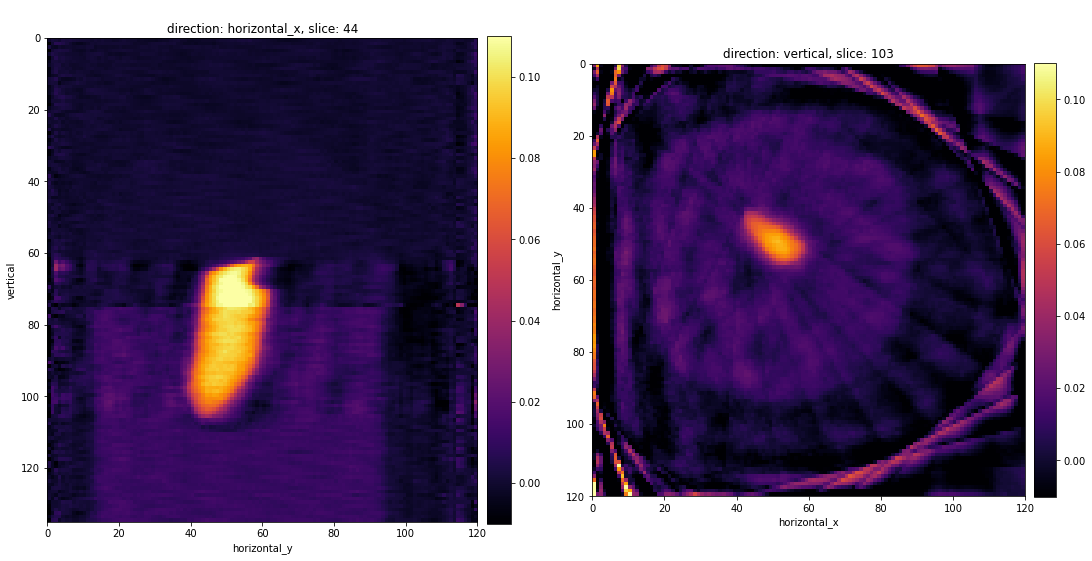

In [28]:
myCGLS.run(500,verbose=True)
myshow(myCGLS.solution)

In [30]:
f1 = 0.5*LeastSquares(A, b)

myGD_LS = GD(x_init=x0, objective_function=f1, step_size=None, max_iteration=100000, update_objective_interval = 10)
myGD_LS.run(3000, verbose=1)

GD setting up
GD configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0     100000         0.000          4.05874e+04
       10     100000         0.076          1.07271e+03
       20     100000         0.062          2.60185e+02
       30     100000         0.057          8.07507e+01
       40     100000         0.054          2.96652e+01
       50     100000         0.053          1.31531e+01
       60     100000         0.052          7.20265e+00
       70     100000         0.052          4.81435e+00
       80     100000         0.051          3.74216e+00
       90     100000         0.050          3.20141e+00
      100     100000         0.050          2.89505e+00
      110     100000         0.050          2.70160e+00
      120     100000         0.049          2.56741e+00
      130     100000         0.049          2.46703e+00
      140     100000         0.049          2.38744e+00
      150     100000

     1440     100000         0.046          1.27834e+00
     1450     100000         0.046          1.27684e+00
     1460     100000         0.046          1.27535e+00
     1470     100000         0.046          1.27387e+00
     1480     100000         0.046          1.27241e+00
     1490     100000         0.046          1.27096e+00
     1500     100000         0.046          1.26953e+00
     1510     100000         0.046          1.26811e+00
     1520     100000         0.046          1.26671e+00
     1530     100000         0.046          1.26532e+00
     1540     100000         0.046          1.26394e+00
     1550     100000         0.046          1.26257e+00
     1560     100000         0.046          1.26122e+00
     1570     100000         0.046          1.25988e+00
     1580     100000         0.046          1.25855e+00
     1590     100000         0.046          1.25723e+00
     1600     100000         0.046          1.25593e+00
     1610     100000         0.046          1.25

     2910     100000         0.046          1.14376e+00
     2920     100000         0.046          1.14317e+00
     2930     100000         0.046          1.14259e+00
     2940     100000         0.046          1.14200e+00
     2950     100000         0.046          1.14142e+00
     2960     100000         0.046          1.14085e+00
     2970     100000         0.046          1.14027e+00
     2980     100000         0.046          1.13970e+00
     2990     100000         0.046          1.13913e+00
     3000     100000         0.046          1.13856e+00
-------------------------------------------------------
     3000     100000         0.046          1.13856e+00
Stop criterion has been reached.



701

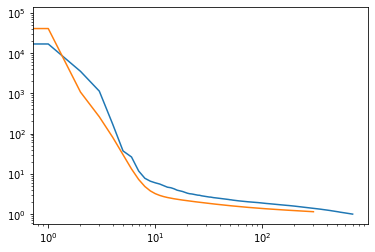

In [31]:
plt.loglog(myCGLS.iterations, myCGLS.objective)
plt.loglog(myGD_LS.objective)
len(myCGLS.objective)

In [ ]:
f1 = LeastSquares(A, b)

D = GradientOperator(ig)
alpha = 1.0
f2 = OperatorCompositionFunction(L2NormSquared(),D)
f = f1 + (alpha**2)*f2

myGD = GD(x_init=x0, objective_function=f, step_size=None, max_iteration=1000, update_objective_interval = 10)
myGD.run(1000, verbose=1)

In [ ]:
plt.figure()
show2D(myGD.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
plt.figure()
show2D(myGD.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

In [ ]:
F = LeastSquares(A, b)
G = IndicatorBox(lower=0.0)
myFISTANN = FISTA(f=F, g=G, x_init=x0, max_iteration=1000)
myFISTANN.run(300, verbose=1)

In [ ]:
plt.figure()
show2D(myFISTANN.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
plt.figure()
show2D(myFISTANN.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

In [ ]:
a1 = 30
G = a1*L1Norm()

myFISTAL1 = FISTA(f=F, g=G, x_init=x0, max_iteration=1000, update_objective_interval=10)

In [ ]:
myFISTAL1.run(300,verbose=1)

In [ ]:
plt.figure()
show2D(myFISTAL1.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
plt.figure()
show2D(myFISTAL1.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

In [ ]:
GTV = 0.02*TotalVariation()

In [ ]:
myFISTATV = FISTA(f=F, g=GTV, x_init=x0 ,max_iteration=1000)

In [ ]:
myFISTATV.run(200,verbose=1)

Show the slices of the TV reconstruction by FISTA:

In [ ]:
show2D(myFISTATV.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
show2D(myFISTATV.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

An even more flexible algorithm for non-smooth problems is the Primal Dual Hybrid Gradient (PDHG) algorithm, which also goes under other names such as the Chambolle-Pock algorithm. In PDHG we can split complicated functionals into simpler parts for which the proximal mapping can be evaluated. PDHG will be covered in more detail in a separate notebook, here it is demonstrated how to set up the same TV-regularized problem we just solved with FISTA. Note how BlockFunctions and BlockOperators are used to specify multiple terms/operators:

In [ ]:
alpha = 0.02
F = BlockFunction(L2NormSquared(b=b), alpha*MixedL21Norm())
K = BlockOperator(A, D)
G = ZeroFunction()
myPDHG = PDHG(f=F, g=G, operator=K, max_iteration=10000)

Run the algorithm for a specified number of iterations with increased verbosity/amount of printing to screen:

In [ ]:
myPDHG.run(5000,verbose=2)

Show the TV-regularized solution obtained by the PDHG Algorithm and note is identical with the one from FISTA:

In [ ]:
show2D(myPDHG.solution.get_slice(horizontal_x=sx),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')
show2D(myPDHG.solution.get_slice(vertical=sz),cmap='inferno',fix_range=(ca1,ca2),origin='upper-left')

CIL Algorithms can record history of objective values (primal and dual for PDHG) for monitoring convergence:

In [ ]:
plt.figure()
plt.loglog(myFISTATV.iterations[1:],  myFISTATV.objective[1:])
plt.loglog(myPDHG.iterations[1:],myPDHG.objective[1:])
plt.loglog(myPDHG.iterations[1:],myPDHG.dual_objective[1:])
plt.loglog(myPDHG.iterations[1:],np.array(myPDHG.objective[1:])-np.array(myPDHG.dual_objective[1:]))
plt.ylim((1e0,1e5))
plt.legend(['FISTA','PDHG primal','PDHG dual','PDHG gap'])
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')